In this notebook, we demonstrate applying the Voronoi tests using the modules on an example sample.

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import Voronoi
import networkx as nx

import sys
sys.path.insert(0, '../') # path to the modules
import graph_create, voronoi_local, jaccard_similarity, center_predict, figure_plot

import warnings 
warnings.filterwarnings('ignore')

-----

## Read in the graph

We read in the vein network and the dots as a combined graph object, with the single dots in non overlapping faces highlighted in orange.

In [2]:
sample = 'PileaTLeaf2'
dot_folder= '../data/sample_example'
vein_folder= '../data/sample_example'

# read the graph from hydathode and vein file:
G = graph_create.graph_creation(sample, dot_folder, vein_folder)

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.



#### Visualize the vein and hydathode graph:

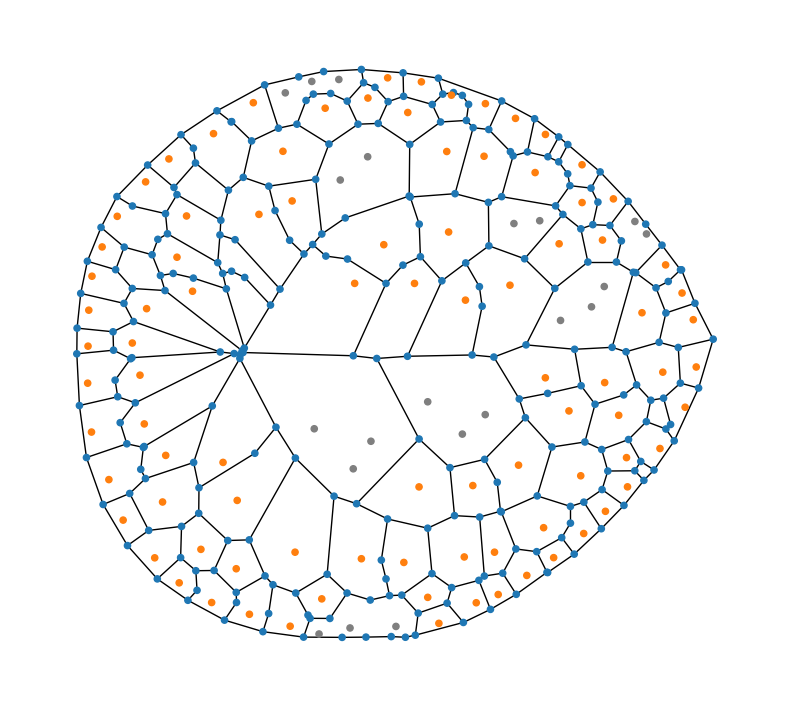

In [3]:
# visualization:
figure_plot.quick_plot(G)

-----

## Perform Voronoi I test

For the eligible hydathodes, we locally test the voronoi properties between them and hydathodes in the adjacent faces. 

We ask whether the line segment connecting two dots is perpendicualar to the shared edges of the face, and whether their distance to the edge is the same, and record the errors.

In [4]:
# create an adjacency matrix holder for polygons:
adj_faces_mat, shared_edges_mat = voronoi_local.shared_edges(G, threshold = 50)
# perform Voronoi I test:
rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat,G.graph['dots_passed'], G, dot_bool = True)
rst[2]

,mean angle error,std angle error,mean distance error,std distance error
0,8.380696,6.707946,0.132071,0.111583


In [5]:
print(f'The number of test pairs we have in this sample is {rst[1].shape[0]}.')

The number of test pairs we have in this sample is 181.


We use the centroid, mid-point and random dots in the face as reference points for the local test.

In [6]:
# create reference point sets:
cent_in_faces, mid_in_faces, rand_in_faces = voronoi_local.random_n_centroid(G)

In [7]:
# use reference point sets as test input:
centroid_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat, cent_in_faces)
midpoint_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat ,mid_in_faces)
random_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat, rand_in_faces)

#### Visualize the polygon pairs we used, via the dual graph:

In [8]:
G_dual = graph_create.make_dual(G, cent_in_faces, mid_in_faces, rand_in_faces, rst[0])

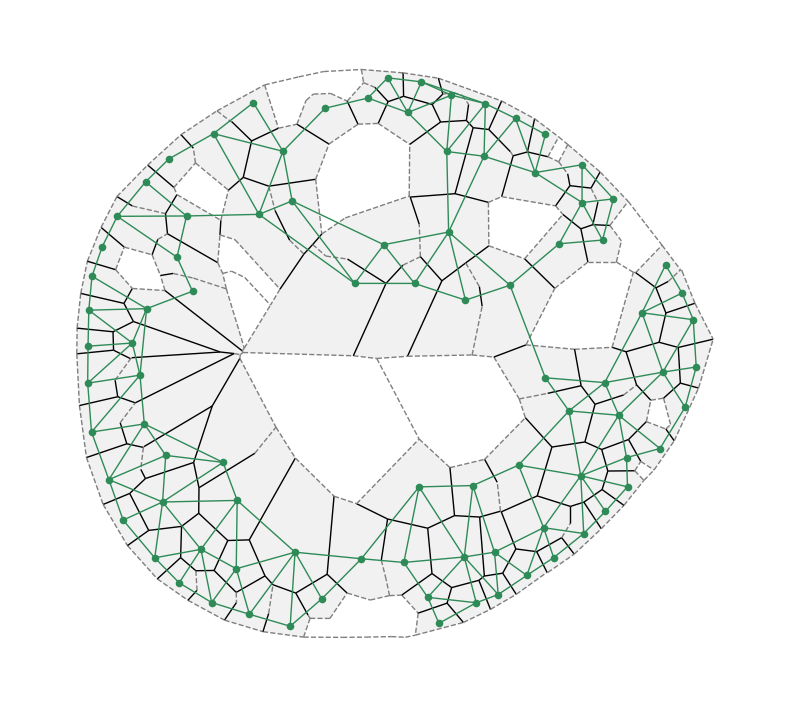

In [9]:
figure_plot.plot_testable(G, G_dual)

In [29]:
# organize results from all point sets:
rst_df = rst[1]
rst_df['type'] = 'hydathode'
cent_df = centroid_rst[1]
cent_df['type'] = 'centroid'
mid_df = midpoint_rst[1]
mid_df['type'] = 'midpoint'
rand_df = random_rst[1]
rand_df['type'] = 'random'

df = pd.concat([rst_df, cent_df, mid_df, rand_df])
df.reset_index(level=0, inplace=True)
df.head()

,index,angle_diff,dist_diff,type
0,0,6.216283,0.645983,hydathode
1,1,21.154174,0.470267,hydathode
2,2,8.569301,0.177255,hydathode
3,3,0.134818,0.041957,hydathode
4,4,2.452549,0.145357,hydathode


#### Visualize reference pointsets:

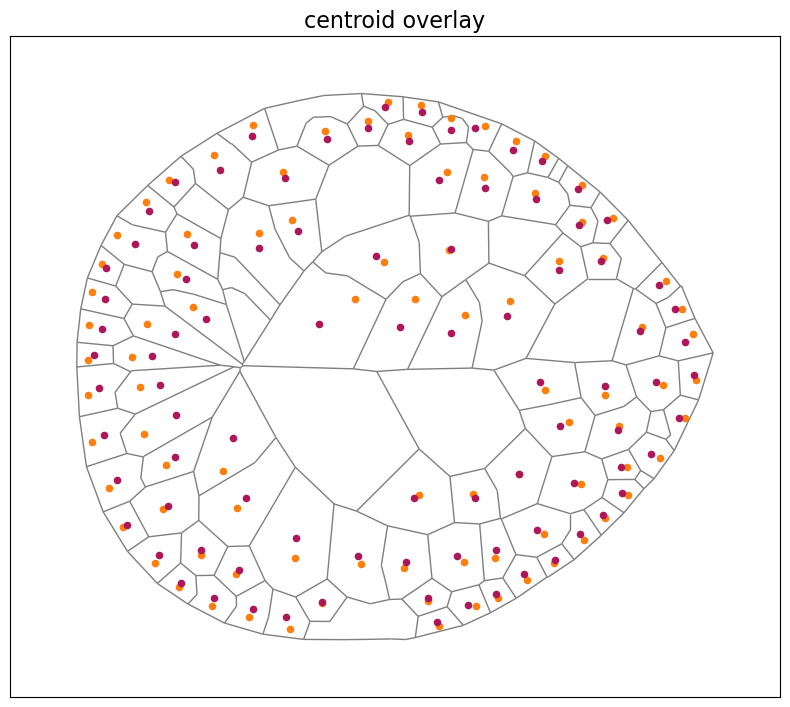

In [30]:
figure_plot.plot_baseline(G, G_dual, pt_type = 'centroid')

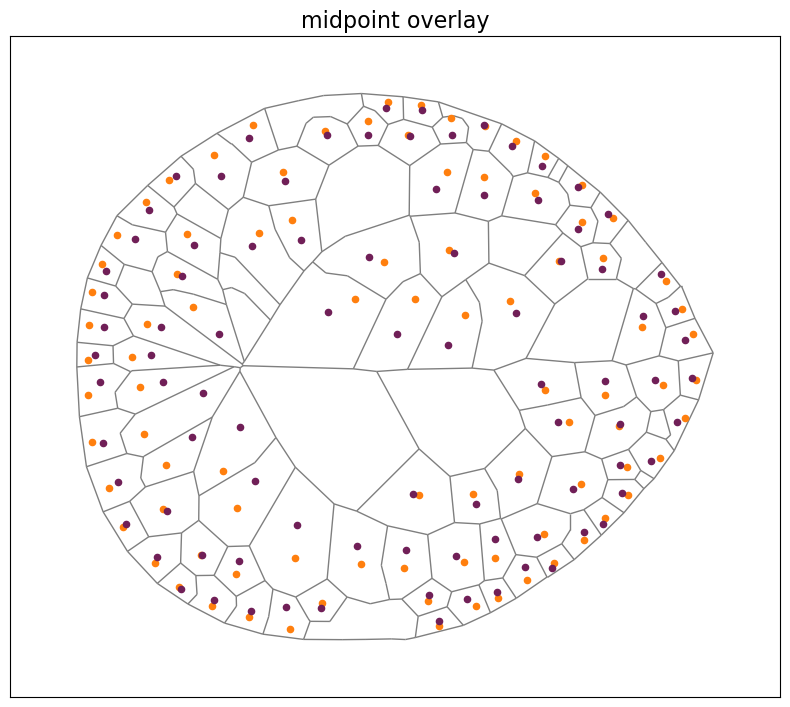

In [31]:
figure_plot.plot_baseline(G, G_dual, pt_type = 'midpoint')

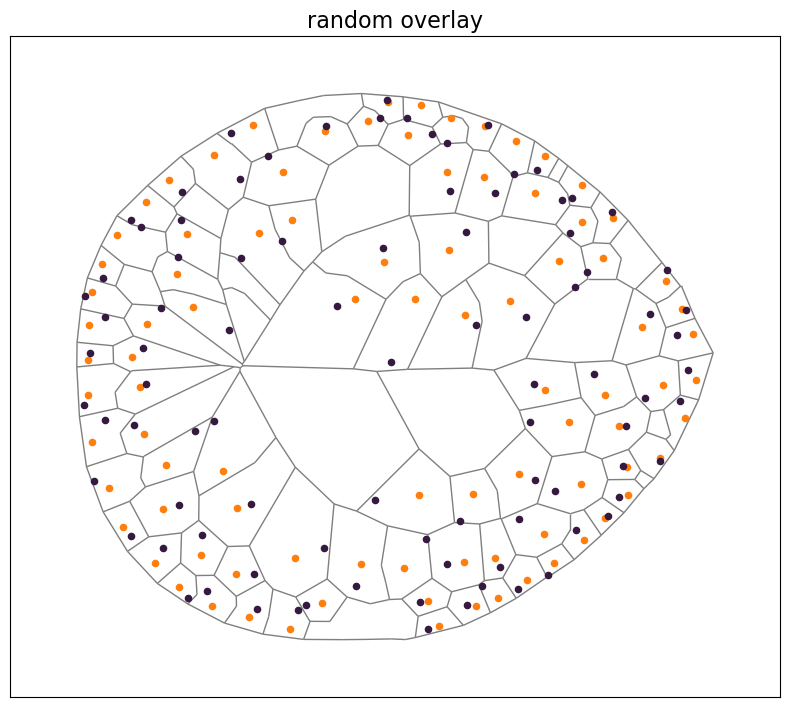

In [32]:
figure_plot.plot_baseline(G, G_dual, pt_type = 'random')

In [33]:
# summarize performance:
baseline_summary = pd.DataFrame(np.array([rst[2].iloc[0].tolist(), centroid_rst[2].iloc[0].tolist(), midpoint_rst[2].iloc[0].tolist(), random_rst[2].iloc[0].tolist()]), 
                                    columns = ['angle_mean', 'angle_std', 'dist_mean', 'dist_std'],
                                    index = ['dot', 'centroid', 'midpoint','random'])

In [15]:
baseline_summary

,angle_mean,angle_std,dist_mean,dist_std
dot,8.380696,6.707946,0.132071,0.111583
centroid,10.125135,8.245539,0.165632,0.129926
midpoint,12.585426,9.609237,0.205141,0.157367
random,20.823283,17.039634,0.377864,0.253758


#### Compare test performance:

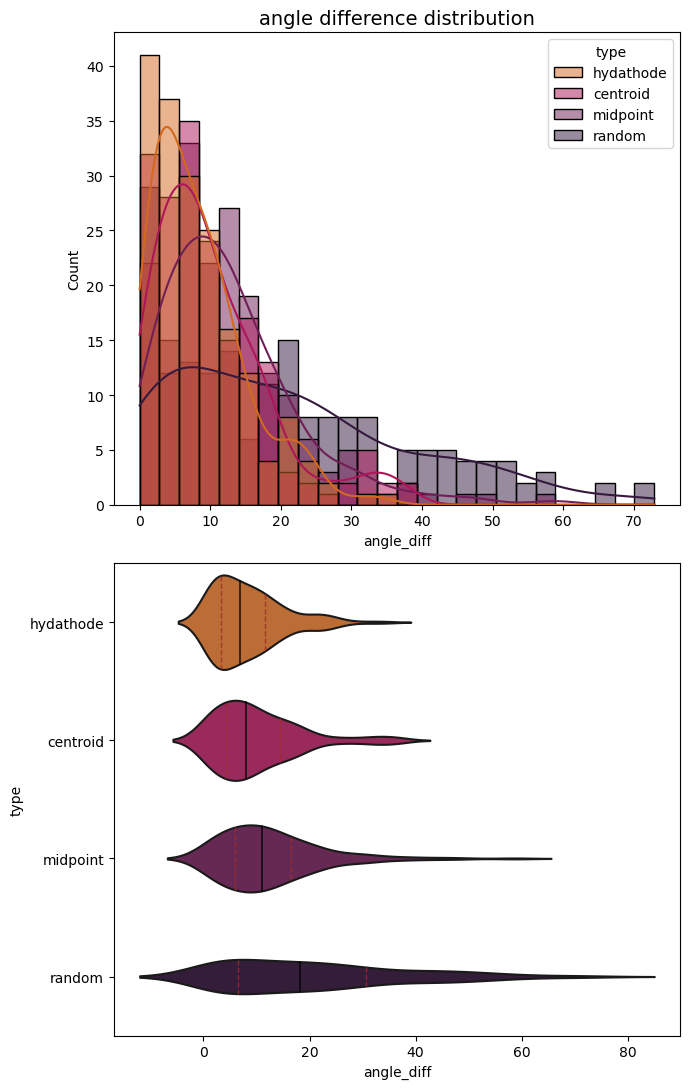

In [16]:
# angle test
figure_plot.plot_dist(df, test = 'angle')

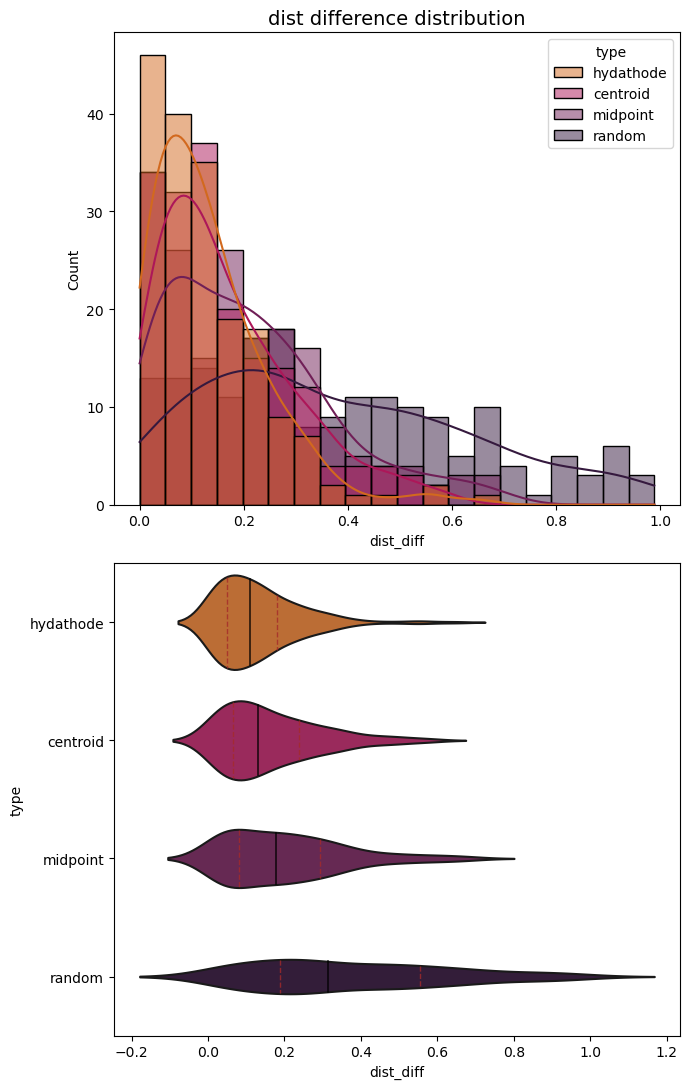

In [17]:
# dist test
figure_plot.plot_dist(df, test = 'dist')

-----

## Perform Voronoi II test

We collect the error when overlapping the true Voronoi graph with the vein graph, and compare them to the reference point sets.

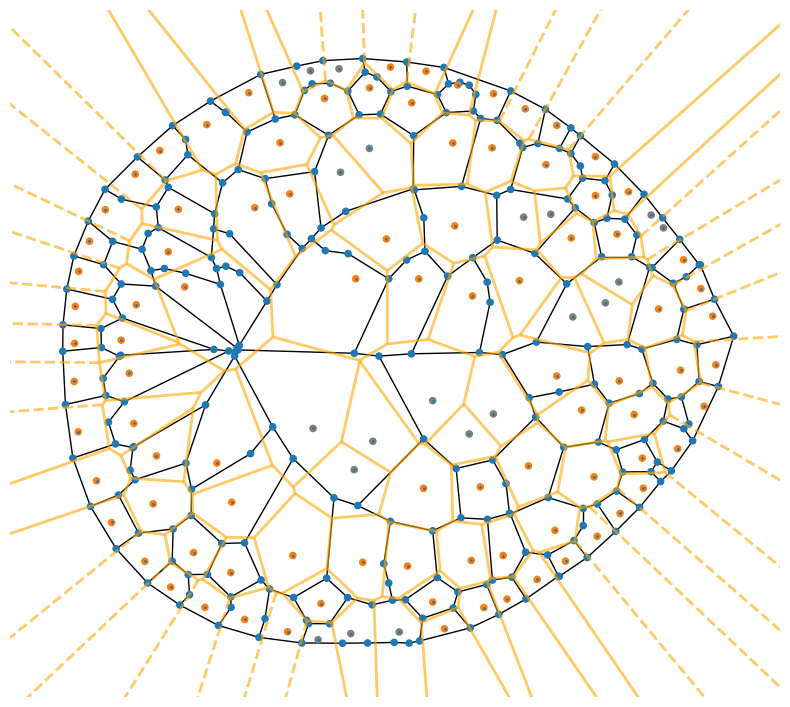

In [34]:
# create Voronoi seeds:
seeds = [n for n in G.nodes if G.nodes[n]['type'] != 'vein']
vor = Voronoi(seeds)
figure_plot.plot_voronoi(G, vor)

In [35]:
# generate bounded Voronoi polygons:
bounded_regions = jaccard_similarity.bounded_polygons(G, vor)
# perform the j-index test:
J_list = jaccard_similarity.overlap_test(G, seeds, bounded_regions, type = 'hydathode')

In [21]:
# repeat the process for the reference point sets:
centroid_seeds, midpoint_seeds, random_seeds = jaccard_similarity.hybrid_seeds(G)

centroid_vor = Voronoi(centroid_seeds)
midpoint_vor =  Voronoi(midpoint_seeds)
random_vor = Voronoi(random_seeds)

centroid_bounded_regions = jaccard_similarity.bounded_polygons(G, centroid_vor)
midpoint_bounded_regions = jaccard_similarity.bounded_polygons(G, midpoint_vor)
random_bounded_regions = jaccard_similarity.bounded_polygons(G, random_vor)

centroid_J_list = jaccard_similarity.overlap_test(G, seeds, centroid_bounded_regions, type = 'centroid')
midpoint_J_list = jaccard_similarity.overlap_test(G, seeds, midpoint_bounded_regions, type = 'midpoint')
random_J_list = jaccard_similarity.overlap_test(G, seeds, random_bounded_regions, type = 'random')

In [22]:
# organize results:
J_df = pd.DataFrame(np.array([J_list, centroid_J_list, midpoint_J_list, random_J_list ]).T, 
                    columns = ['dots', 'centroid', 'midpoint', 'random'])
J_df.mean() 

dots        0.727779
centroid    0.708472
midpoint    0.658440
random      0.477732
dtype: float64

#### Visualize Voronoi II overlap error: 

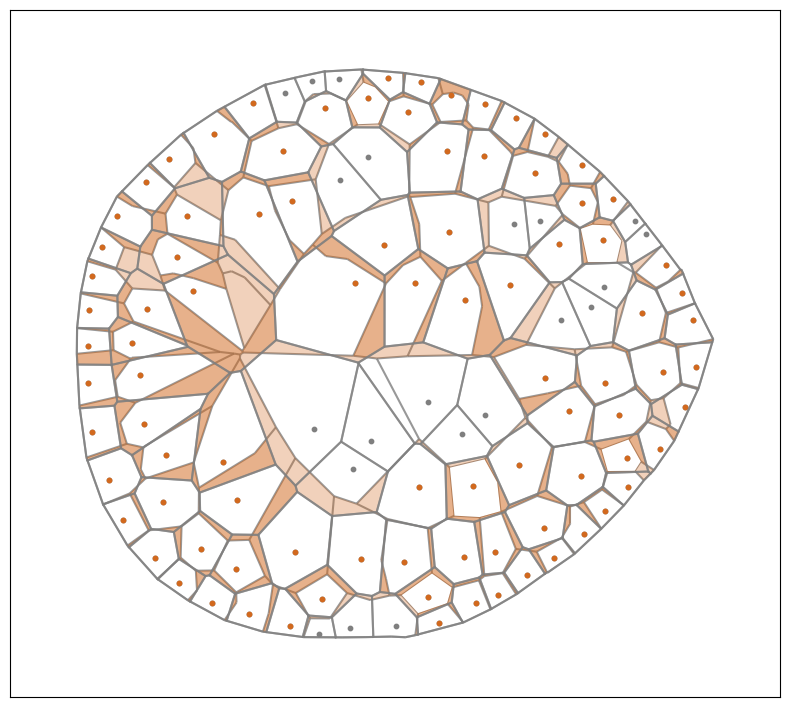

In [23]:
# hydathodes:
single_dots = [G.nodes[seed]['type'] == 'single_dot' for seed in seeds] # used to highlight the color of single-dot 
figure_plot.plot_overlap_diff(G, bounded_regions, seeds, single_dots, type = 'hydathode')

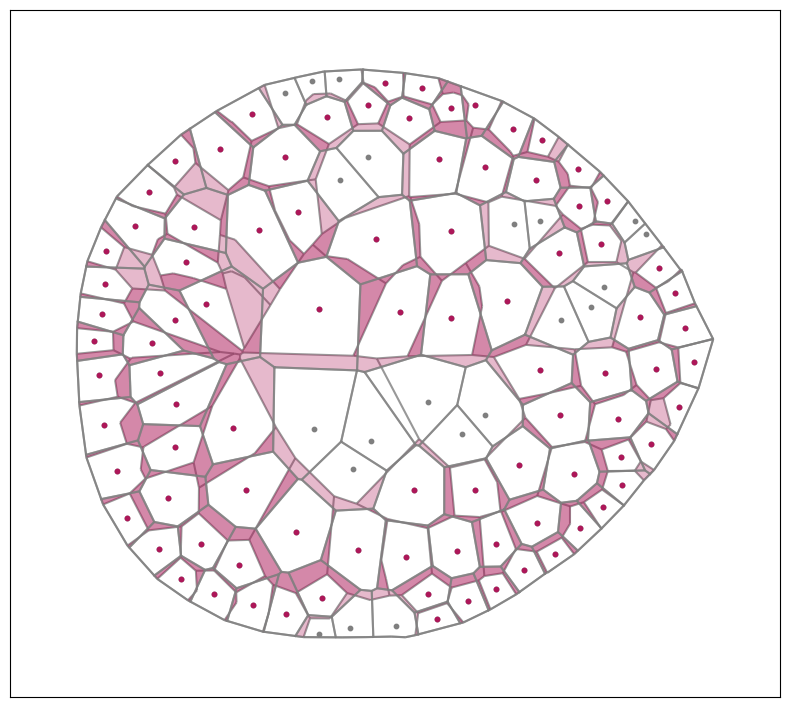

In [24]:
# centroid:
figure_plot.plot_overlap_diff(G, bounded_regions= centroid_bounded_regions, seeds = centroid_seeds, single_dot =  single_dots, type = 'centroid')

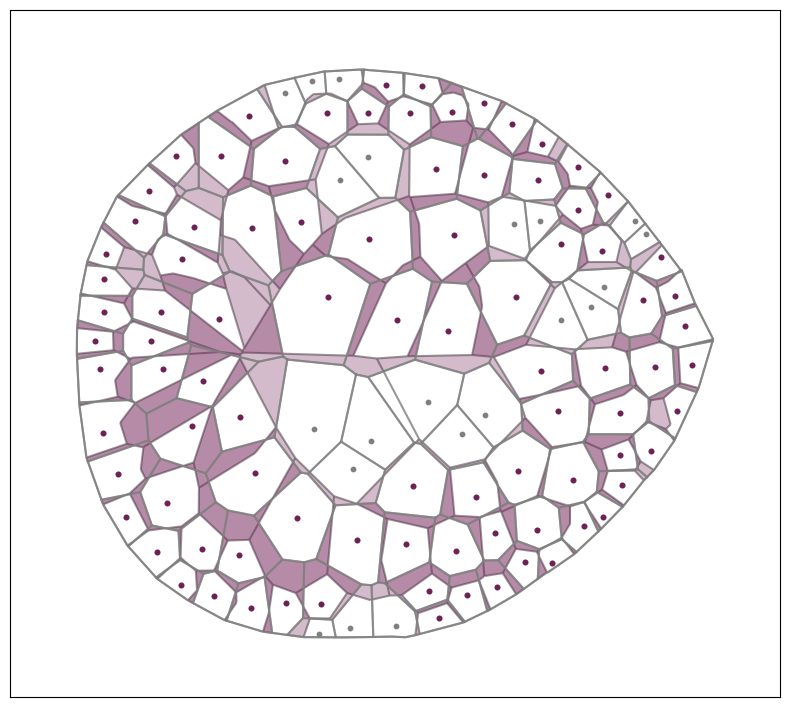

In [25]:
# midpoint:
figure_plot.plot_overlap_diff(G, bounded_regions= midpoint_bounded_regions, seeds = midpoint_seeds, single_dot =  single_dots, type = 'midpoint')

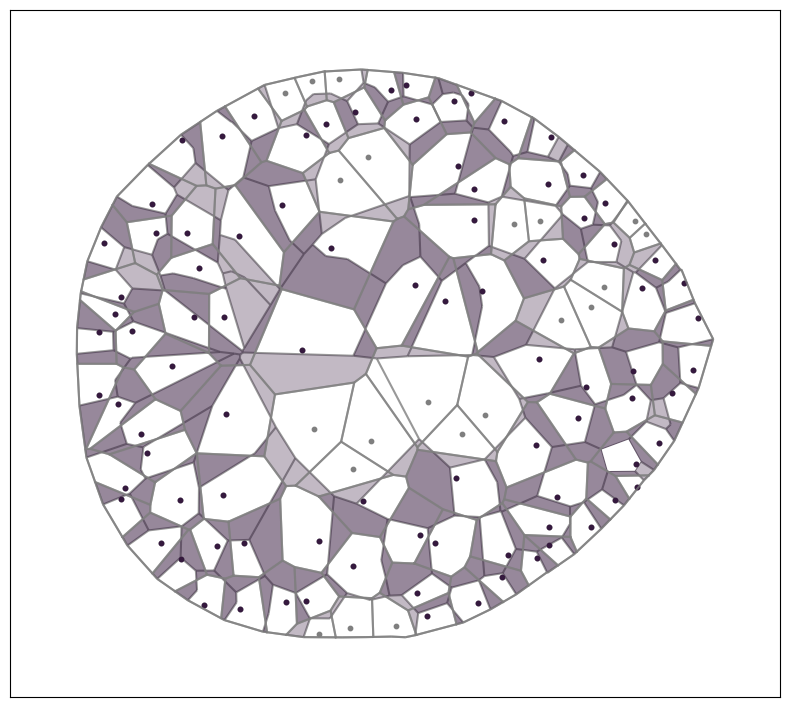

In [26]:
# random:
figure_plot.plot_overlap_diff(G, bounded_regions = random_bounded_regions, seeds = random_seeds, single_dot =  single_dots, type = 'random')

-----

## Perform Voronoi III test

By using the shared edges of adjacent polygons, we construct a linear system to predict the best center locations give the Voronoi geometry.

In [27]:
# we only predict for the subgraph whose dual is a single connected components
greatest_dual =  G_dual.subgraph(max(nx.connected_components(G_dual), key=len))
# get the subgraph nodes and the indices:
_, _, g_list, g_nodes_index = center_predict.slope_intercept_gcc(G, G_dual, shared_edges_mat, test_type= 'random')
# random draw 100 times and output the one results in the least error:
ceiling, predicted_centers = center_predict.random_all(G, G_dual, greatest_dual, shared_edges_mat, g_list, g_list)

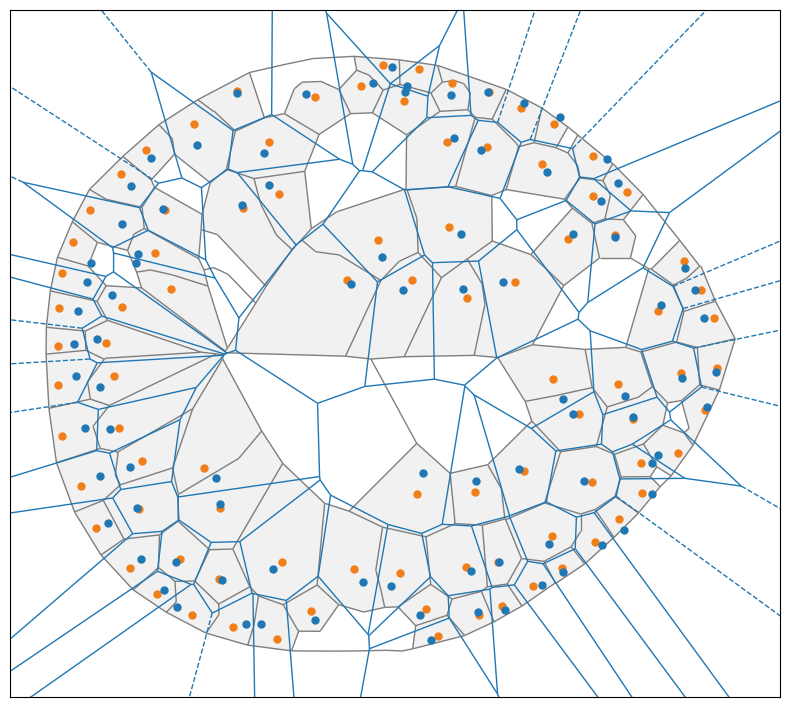

In [28]:
# overlap between the true Voronoi given the predicted centers, and the vein graph
figure_plot.plot_predicted_voronoi(G, predicted_centers)